adding pink to the data file with hatchery release
then making visualization for hatchery release

In [2]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sys import platform
from datetime import timedelta
import matplotlib.gridspec as gridspec
import math

if platform == "linux" or platform == "linux2":
    data_string = "/home/maria/Documents/data/pied_piper/"
    output_string = "/home/maria/Documents/output/pied_piper/"
else:
    data_string = "C:/Users/maria/OneDrive/Documents/data/pied_piper/"
    output_string = "C:/Users/maria/OneDrive/Documents/output/pied_piper/"

In [6]:
df = pd.read_csv("https://www.rmis.org/reports/CSV15035.txt")

# add column for species name
df_species = pd.DataFrame({'species':[1,2,3,4,5,6,7,8,9], 
                          'species_name':['chinook','coho','steelhead', 
                                          'sockeye','chum','pink','masu', 'cutthroat','atlantic']})

df_combine = df.merge(df_species, how = 'left', validate = 'many_to_one', on = 'species')

# change date format

#calculate unclipped and untagged
df_combine['first_release_date'] =  pd.to_datetime(df_combine['first_release_date'], format='%Y%m%d')
df_combine['last_release_date'] =  pd.to_datetime(df_combine['last_release_date'], format='%Y%m%d')
df_combine['total'] = (df_combine['tagged_adclipped'] + df_combine['tagged_unclipped'] + 
                       df_combine['untagged_adclipped'] + df_combine['untagged_unclipped'] + 
                       df_combine['untagged_unknown'])
df_combine['prop_untagged_unclipped'] = (df_combine['untagged_unclipped']+ 
                                         df_combine['untagged_unknown'])/df_combine['total']

#calculate age
df_combine['age'] = df_combine['first_release_date'].dt.year - df_combine['brood_year'] - 1

subset_df = df_combine[(df_combine['first_release_date'].dt.year >= 2005) & (df_combine['first_release_date'].dt.year <= 2020)]

#need to combine this dataset with the hatchery dataset




In [5]:
#pink0
pink0_df = pd.DataFrame()
pink0_df['Date'] = subset_df['first_release_date'][subset_df['species_name'] == 'pink'][subset_df['age']==0]
pink0_df['pink0_hatchery_total_release'] = subset_df['total'][subset_df['species_name'] == 'pink'][subset_df['age']==0]

pink0_df['release_strategy_pink0'] = subset_df['release_strategy'][subset_df['species_name'] == 'pink'][subset_df['age']==0]
pink0_df['release_strategy_pink0'] = pink0_df['release_strategy_pink0'].astype(str)
pink0_df['pink0_untagged_unclipped'] = subset_df['untagged_unclipped'][subset_df['species_name'] == 'pink'][subset_df['age']==0]

pink0_df['pink0_untagged_unclipped_prop'] = subset_df['prop_untagged_unclipped'][subset_df['species_name'] == 'pink'][subset_df['age']==0]
grouped_pink0_df = pink0_df.groupby(by=["Date"]).agg({'pink0_hatchery_total_release':'sum',
                                                            'pink0_untagged_unclipped':'sum',
                                                            'release_strategy_pink0': ' '.join})
grouped_pink0_df['pink0_untagged_unclipped_prop'] = (grouped_pink0_df['pink0_untagged_unclipped']/
                                                           grouped_pink0_df['pink0_hatchery_total_release'])


grouped_pink0_df

,pink0_hatchery_total_release,pink0_untagged_unclipped,release_strategy_pink0,pink0_untagged_unclipped_prop
Date,,,,
2008-05-13,24473,1835,nan,0.074981
2010-04-20,52239,3395,nan nan,0.064990
2010-05-05,61271,3891,nan nan,0.063505
2012-04-14,103568,0,nan nan nan,0.000000
2018-05-01,10550,10550,nan,1.000000
2020-04-14,13600,272,nan,0.020000


In [9]:
df_trap = pd.read_csv(data_string + "dungeness/dungeness_all_days_hatchery_release_new.csv", header = 0)


df_trap['Date']=pd.to_datetime(df_trap['Date'])
df_trap = df_trap.merge(grouped_pink0_df, on = 'Date', how = 'left', validate = 'one_to_one')
df_trap.to_csv(data_string + "dungeness/dungeness_all_days_hatchery_release_new.csv")

In [10]:
def hatchery_visualization_paper(df, species_age="chinook0", hatchery_prop=True):
    string_hatchery = species_age + "_hatchery_total_release"
    string_hatchery_perhour = species_age + "_hatchery_perhour"
    string_wild_perhour = species_age + "_wild_perhour"
    string_prop = species_age + "_untagged_unclipped_prop"
    string_release_strategy = "release_strategy_" + species_age 

    species_list = df['Date'][~np.isnan(df[string_hatchery])]
    total_number_releases = len(species_list)
    count = 0
    for i, j in enumerate(species_list):
        index = species_list.index[i]
        if i < total_number_releases - 1:
            next_index = species_list.index[i + 1]
            days_inbetween = (species_list[next_index] - j).days
            if days_inbetween < 50:
                continue
            else:
                count = count + 1

    total_plots = count + 1

    fig = plt.figure(figsize=(15, 15))
    if species_age == "coho1":
        title = "Coho yearlings"
    elif species_age == "chinook0":
        title = "Chinook subyearlings"
    elif species_age == "steelheadsmolt":
        title = "Steelhead smolts"
    elif species_age == "pink0":
        title = "Pink fry"
    plt.suptitle(title, fontsize=20)
    outer = gridspec.GridSpec(math.ceil(total_plots / 4), 4, wspace=0.2, hspace=0.4)

    count_releases = 0
    count_plot = 0
    line_handles = []  # List to hold line handles
    line_labels = []  # List to hold line labels

    # loop over all releases
    for i, j in enumerate(species_list):
        index = species_list.index[i]
        if count_releases > 0:
            count_releases = count_releases - 1
            continue
        else:
            if i < total_number_releases - 1:
                indices = species_list.index[i + 1:]
                count_releases = 0
                release_list = [index]
                for k in indices:
                    days_inbetween = (species_list[k] - j).days
                    if days_inbetween < 50:
                        count_releases = count_releases + 1
                        release_list.append(k)
            else:
                release_list = [index]

        window = 50
        hatchery = df[string_hatchery_perhour][release_list[0]:release_list[0] + window]
        wild = df[string_wild_perhour][release_list[0]:release_list[0] + window]

        if np.isnan(hatchery).all():
            continue

        inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                                                 subplot_spec=outer[count_plot], wspace=0.1, hspace=0.6)
        count_plot = count_plot + 1

        for j in range(2):
            ax = plt.Subplot(fig, inner[j])
            if j == 0:
                line, = ax.plot(range(window),
                                df[string_hatchery_perhour][release_list[0]:release_list[0] + window],
                                "cadetblue")
                ax.set_title(str(df['Date'].dt.year[release_list[0]]), fontweight="bold")
                
                label = "Hatchery"
            else:
                line, = ax.plot(range(window),
                                df[string_wild_perhour][release_list[0]:release_list[0] + window],
                                "salmon")
                label = "Wild"
                
                if hatchery_prop:
                    title_list = []
                    plt.axvline(x=0, c="black", alpha=0.5)
                    title_list.append(df[string_release_strategy][release_list[0]])
                    if len(release_list) > 1:
                        count_release_list = 0
                        days_after_first_release = 0
                        
                        for release_list_i in release_list:
                            prop = df[string_prop][release_list_i]
                            count_release_list = count_release_list + 1
                            

                            if count_release_list > 1:
                                title_list.append(df[string_release_strategy][release_list_i])
                                plt.axvline(days_after_first_release + release_list_i - previous_release,
                                            c="black", alpha=0.5)

                                days_after_first_release = (days_after_first_release +
                                                           release_list_i - previous_release)

                            previous_release = release_list_i
                    final_title = ', '.join(title_list)
                    ax.set_title(final_title)
            if i == 0:
                line_handles.append(line)  # Add line handle to list
                line_labels.append(label)  # Add line label to list
            fig.add_subplot(ax)
            

    fig.supxlabel("Days after first hatchery release", fontsize=20)
    fig.supylabel("Fish per hour", fontsize=20)

    # Add common legend
    fig.legend(line_handles, line_labels, loc='center', bbox_to_anchor=(0.5, 0.08), ncol=len(line_handles), 
               fontsize = 16)
#     print(str(df['Date'].dt.year[release_list[0]]) + ' ' + df['release_strategy_chinook0'][release_list[0]])
  
    
    plt.savefig(output_string + species_age + '_hatchery_wild_each_year_release_strategy_' + str(hatchery_prop) + '.jpeg',
                dpi=500)

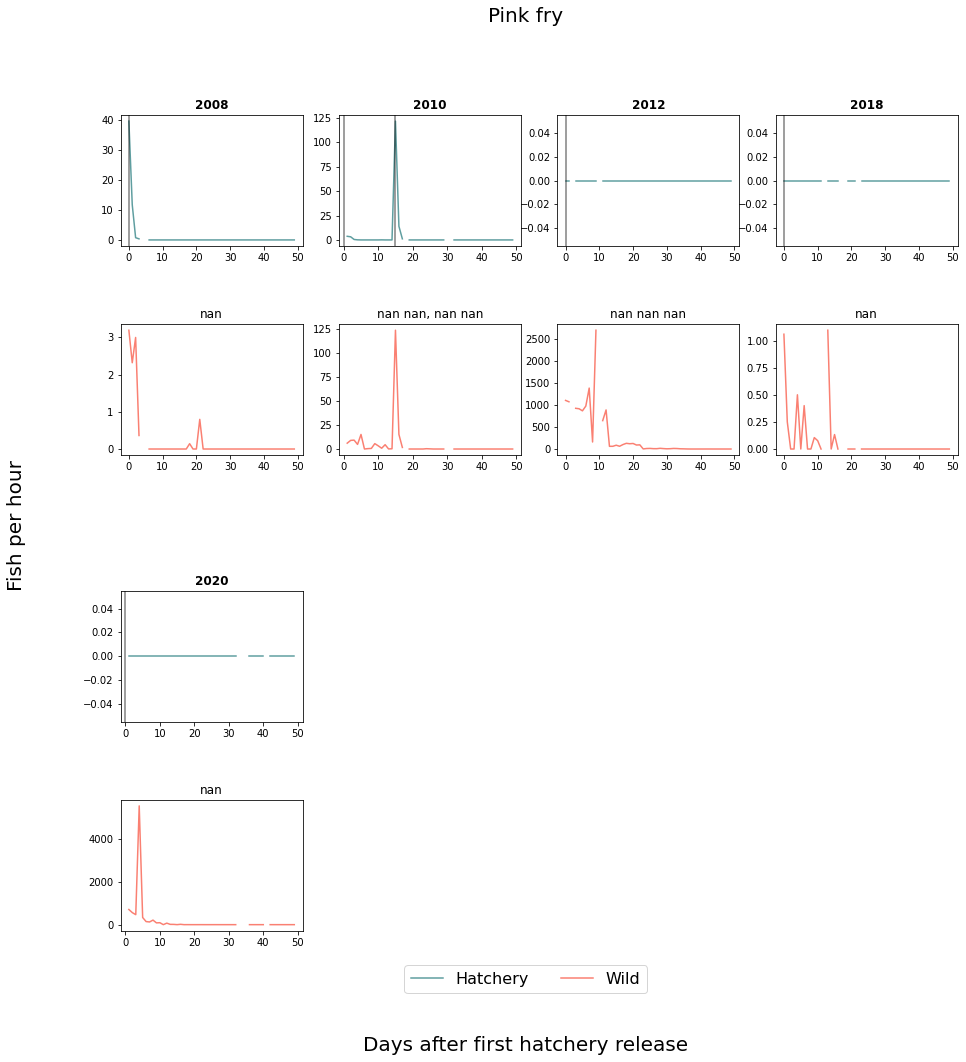

In [11]:
hatchery_visualization_paper(df_trap, "pink0", True)